In [161]:
#@title Data retrieval
import os, requests

fname = '../data/joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [162]:
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [163]:
!pip install mne --quiet

In [164]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# show columns
print(alldat[0][2])



{'V': array([[-1.464  , -1.419  ,  0.2238 , ..., -0.2615 , -1.287  , -1.196  ],
       [-1.521  , -1.522  ,  0.1215 , ..., -0.352  , -1.415  , -1.218  ],
       [-1.591  , -1.627  ,  0.01779, ..., -0.4363 , -1.521  , -1.243  ],
       ...,
       [ 1.163  ,  1.085  ,  0.3865 , ...,  1.066  ,  0.951  ,  0.618  ],
       [ 1.135  ,  1.058  ,  0.4216 , ...,  1.043  ,  0.9526 ,  0.5923 ],
       [ 1.066  ,  1.014  ,  0.433  , ...,  1.043  ,  0.954  ,  0.564  ]],
      dtype=float16), 'targetX': array([[3054],
       [3054],
       [3054],
       ...,
       [2755],
       [2755],
       [2755]], dtype=uint16), 'targetY': array([[12103],
       [12103],
       [12103],
       ...,
       [13182],
       [13182],
       [13182]], dtype=uint16), 'cursorX': array([[ 1786],
       [ 1786],
       [ 1786],
       ...,
       [10804],
       [10804],
       [10804]], dtype=uint16), 'cursorY': array([[19416],
       [19416],
       [19416],
       ...,
       [26907],
       [26907],
       [26907

{'V': <class 'numpy.ndarray'>, 'targetX': <class 'numpy.ndarray'>, 'targetY': <class 'numpy.ndarray'>, 'cursorX': <class 'numpy.ndarray'>, 'cursorY': <class 'numpy.ndarray'>, 'locs': <class 'numpy.ndarray'>, 'hemisphere': <class 'list'>, 'lobe': <class 'list'>, 'gyrus': <class 'list'>, 'Brodmann_Area': <class 'list'>}
Shape of cursorX: (259920, 1)
Shape of cursorY: (259920, 1)
Shape of targetX: (259920, 1)
Shape of targetY: (259920, 1)


Text(0.5, 0, 'Time')

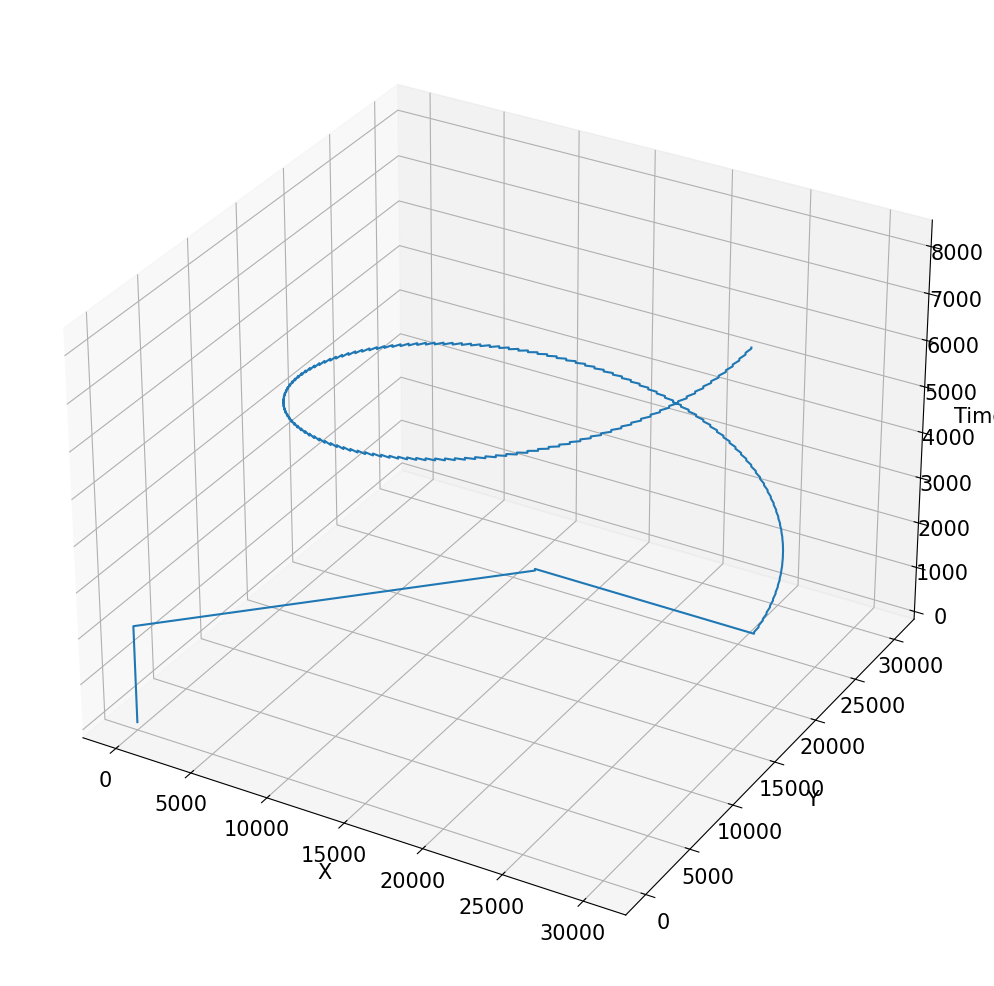

In [206]:
# Select just one of the recordings here. This is subject 1, block 1.
subject = 0
trial = 3
dat = alldat[subject][trial]

print({k: type(dat[k]) for k in dat.keys()})    
# data visualisation for one trial
plt.figure(figsize=(20, 20))

# Check the shapes of the arrays
print(f"Shape of cursorX: {dat['cursorX'].shape}")
print(f"Shape of cursorY: {dat['cursorY'].shape}")
print(f"Shape of targetX: {dat['targetX'].shape}")
print(f"Shape of targetY: {dat['targetY'].shape}")

# Reshape if necessary
cursorX = dat['cursorX'].reshape(-1)
cursorY = dat['cursorY'].reshape(-1)
targetX = dat['targetX'].reshape(-1)
targetY = dat['targetY'].reshape(-1)

interval = 250//8
# combine x and y to get complex numbers in polar coordinates
cursor = cursorX + 1j * cursorY
target = targetX + 1j * targetY
cursor = cursor[:len(cursor)//interval] 
target = target[:len(target)//interval]
# project to 3d across time and plot
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(211, projection='3d')
#ax.plot(np.real(cursor), np.imag(cursor), np.arange(len(cursor)))
ax.plot(np.real(target), np.imag(target), np.arange(len(cursor)))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time')

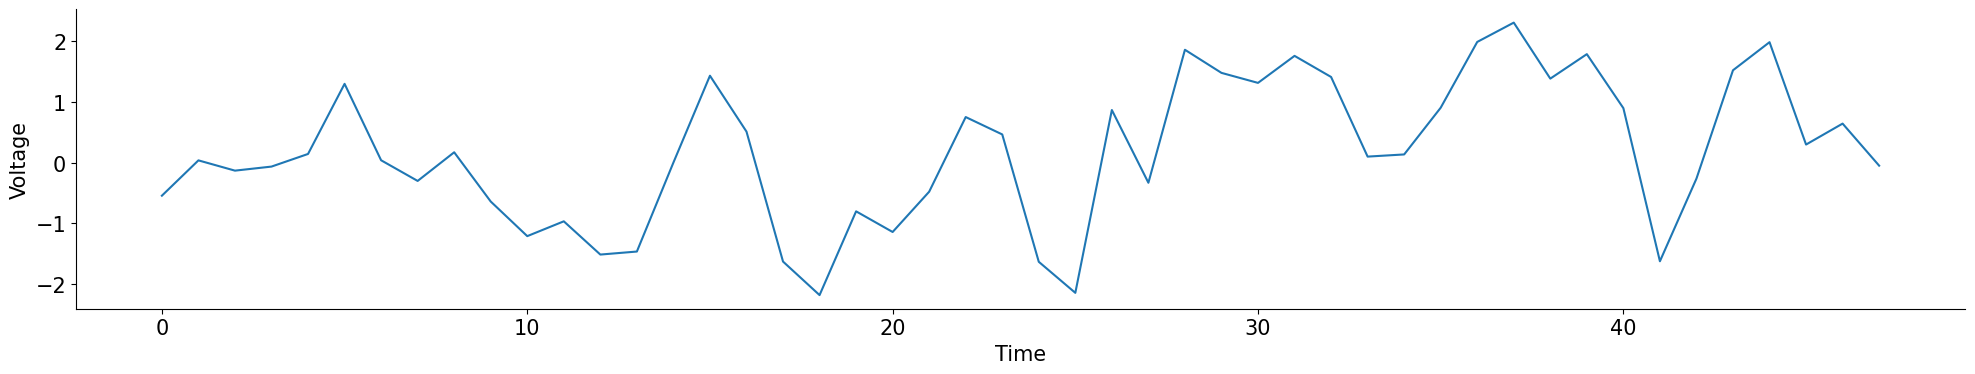

In [166]:
# plot the channel voltage across time
# plt.subplot(212)
plt.plot(dat['V'][:len(cursor)//4][6])
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

# Alpha Band Analysis

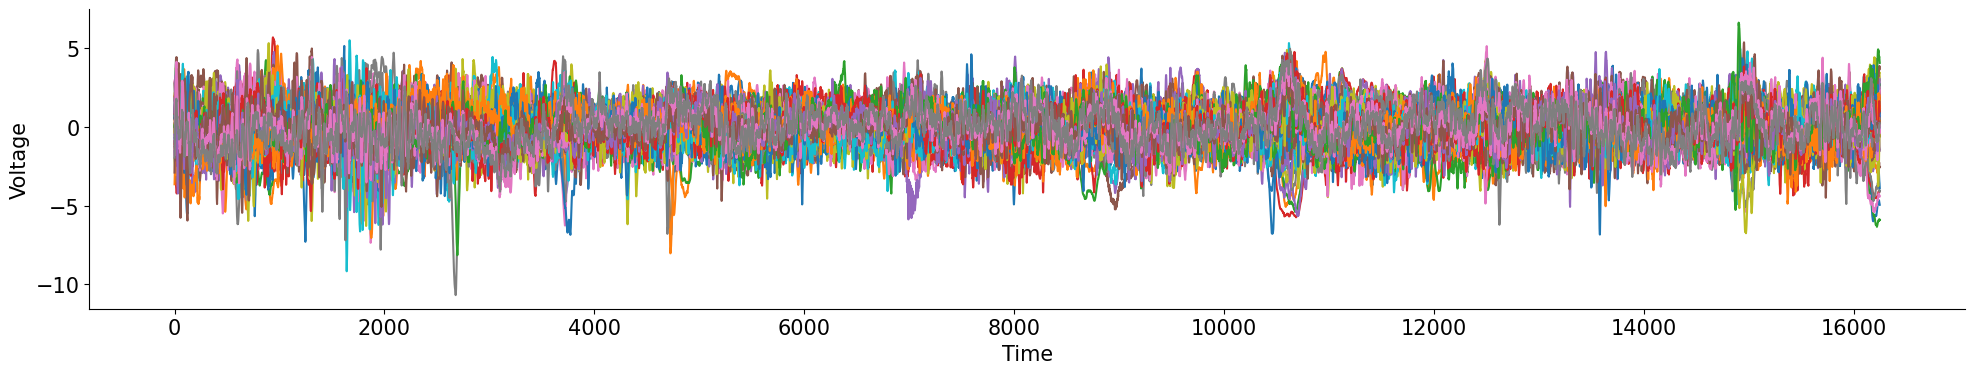

In [167]:
# rereference voltage data
V = dat['V'][:len(cursor)//4]
V -= np.mean(V, axis=0)
V /= np.std(V, axis=0)
plt.plot(V)
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

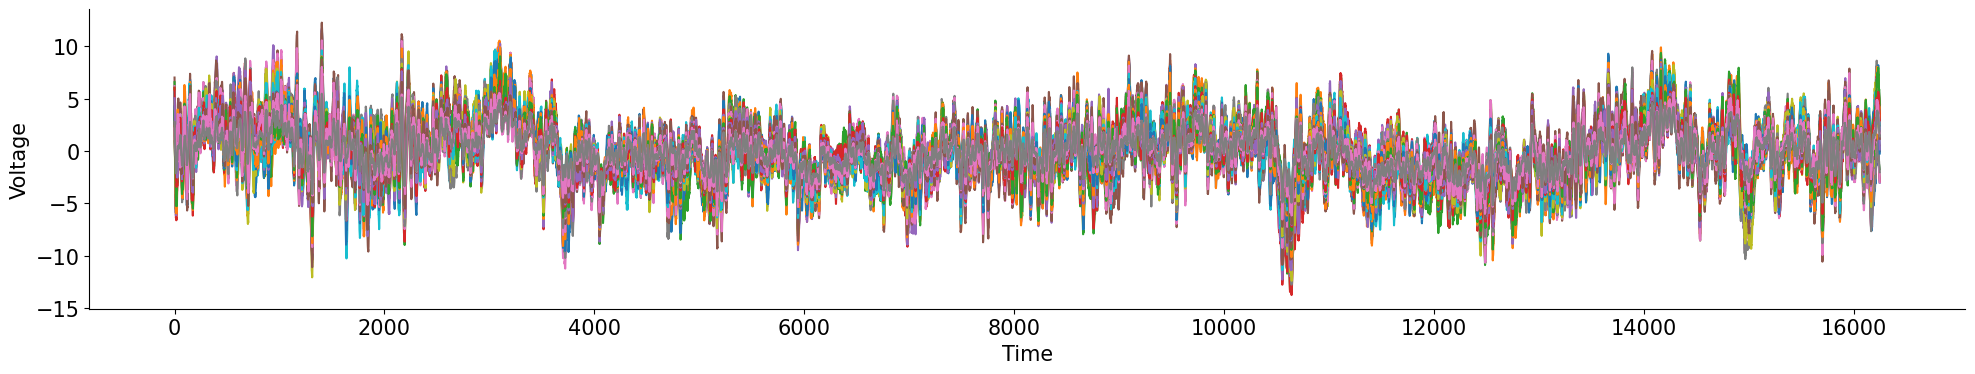

In [168]:
# 4th order butterworth filter
from scipy.signal import butter, filtfilt
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def full_rectify(data):
    return np.abs(data)

def gaus_smooth(data, sigma=1):
    from scipy.ndimage import gaussian_filter1d
    return gaussian_filter1d(data, sigma)

def downsample(data, factor=2):
    return data[::factor]

def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

def full_alpha_band(data, fs=1000):
    butt = butter_bandpass_filter(data, 8, 12, fs)
    rect = full_rectify(butt)
    smooth = gaus_smooth(rect)
    down = downsample(smooth)
    return normalize_signal(down)



# Filter the data
fs = 1000
lowcut = 0.1
highcut = 300

V = butter_bandpass_filter(V, lowcut, highcut, fs, order=4)
plt.plot(V)
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

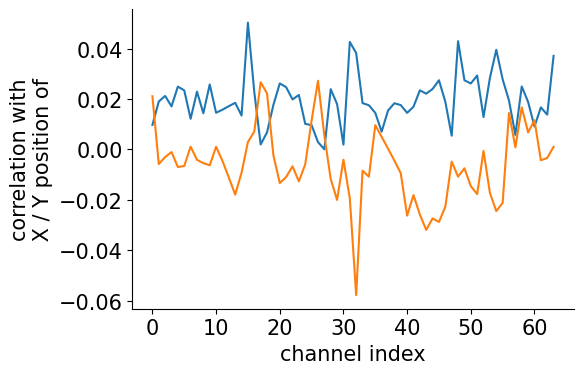

In [169]:
# compute correlations between voltage data and X/Y position of target
from scipy import signal
dat = alldat[0][1]

V = dat['V'].astype('float32')

nt, nchan = V.shape

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()

cx = np.zeros(nchan, )
cy = np.zeros(nchan, )
for j in range(nchan):
  cx[j] = np.corrcoef(V[:, j], targetX)[0, 1]
  cy[j] = np.corrcoef(V[:, j], targetY)[0, 1]

plt.subplot(1, 4, 1)
plt.plot(cx)
plt.plot(cy)
plt.ylabel('correlation with\n X / Y position of ')
plt.xlabel('channel index')
plt.show()

In [170]:
# run PCA on the voltage data in relation to the X/Y position of the target

V = dat['V'].astype('float32')


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
V_scaled = scaler.fit_transform(V, targetX)



In [171]:
# Initialize PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)  # You can choose the number of components you want

# Fit and transform the data
V_pca = pca.fit_transform(V_scaled, targetX)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by component: {explained_variance}')

Explained variance by component: [0.64868154 0.06703279 0.05366821]


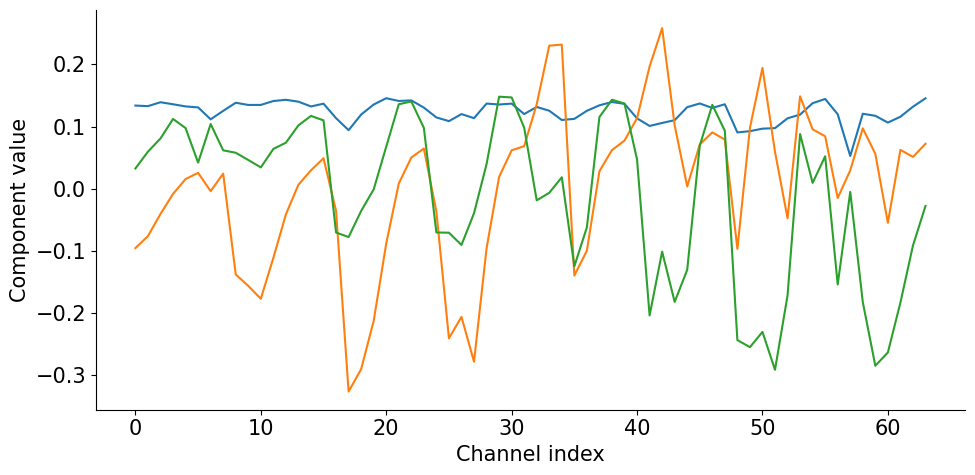

In [172]:
# extract the component columns and its channel index
components = pca.components_
channel_index = np.arange(nchan)

# plot the components
plt.figure(figsize=(10, 5))
plt.plot(components.T)
plt.xlabel('Channel index')
plt.ylabel('Component value')
plt.show()



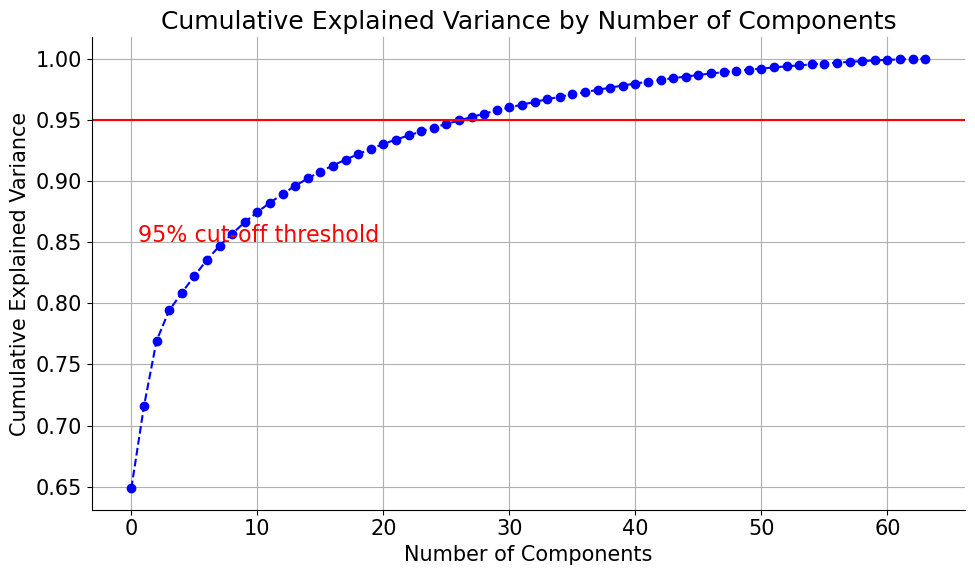

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA with all components
pca = PCA().fit(V_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)
plt.grid(True)
plt.show()


In [174]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact


def plot_3d_pca(azim, elev):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(V_pca[:, 0], V_pca[:, 1], V_pca[:, 2], c='blue', edgecolor='k', s=50)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of ECoG Data')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interact(plot_3d_pca, azim=widgets.IntSlider(min=0, max=360, step=1, value=30), elev=widgets.IntSlider(min=0, max=90, step=1, value=30))




interactive(children=(IntSlider(value=30, description='azim', max=360), IntSlider(value=30, description='elev'…

<function __main__.plot_3d_pca(azim, elev)>

In [175]:
# feature extraction

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Select the top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(V_scaled, targetX)

# Get columns selected
selected_columns = selector.get_support(indices=True)
print(f'Selected columns: {selected_columns}')

# scatter plot of the selected features in 2d and 3d with widgets
def plot_2d_features(f1, f2):
    plt.figure(figsize=(10, 8))
    plt.scatter(V_scaled[:, f1], V_scaled[:, f2], c='blue', edgecolor='k', s=50)
    plt.xlabel(f'Feature {f1}')
    plt.ylabel(f'Feature {f2}')
    plt.title('2D Scatter Plot of Selected Features')
    plt.show()

def plot_3d_features(f1, f2, f3):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(V_scaled[:, f1], V_scaled[:, f2], V_scaled[:, f3], c='blue', edgecolor='k', s=50)
    ax.set_xlabel(f'Feature {f1}')
    ax.set_ylabel(f'Feature {f2}')
    ax.set_zlabel(f'Feature {f3}')
    ax.set_title('3D Scatter Plot of Selected Features')
    plt.show()

# iter by selected columns, max by selected columns, min by selected columns
interact(plot_2d_features, f1=widgets.IntSlider(min=0, max=max(selected_columns), step=1, value=0), f2=widgets.IntSlider(min=0, max=max(selected_columns), step= 1, value=1))

Selected columns: [ 5  7 12 13 14 16 26 43 58 59]


interactive(children=(IntSlider(value=0, description='f1', max=59), IntSlider(value=1, description='f2', max=5…

<function __main__.plot_2d_features(f1, f2)>

Creating RawArray with float64 data, n_channels=64, n_times=67180
    Range : 0 ... 67179 =      0.000 ...    67.179 secs
Ready.


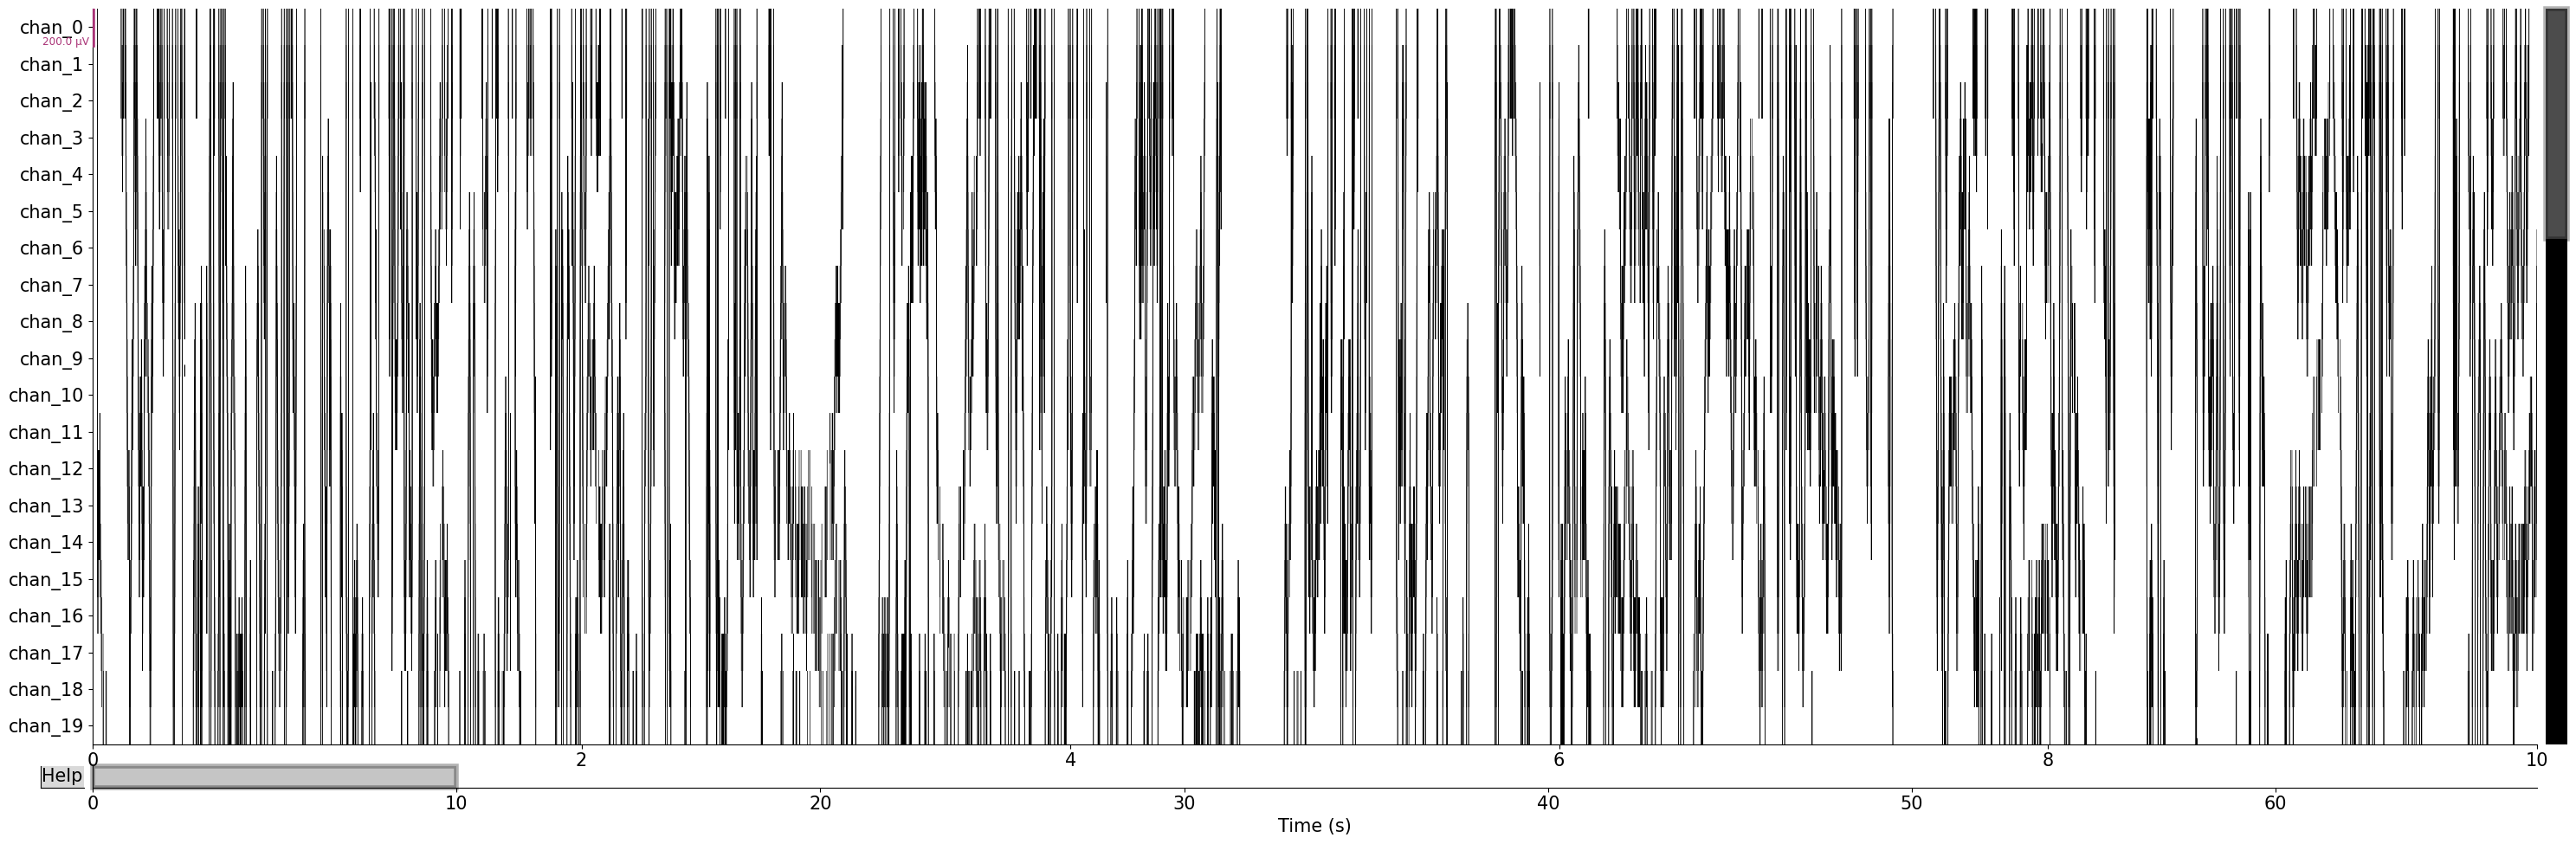

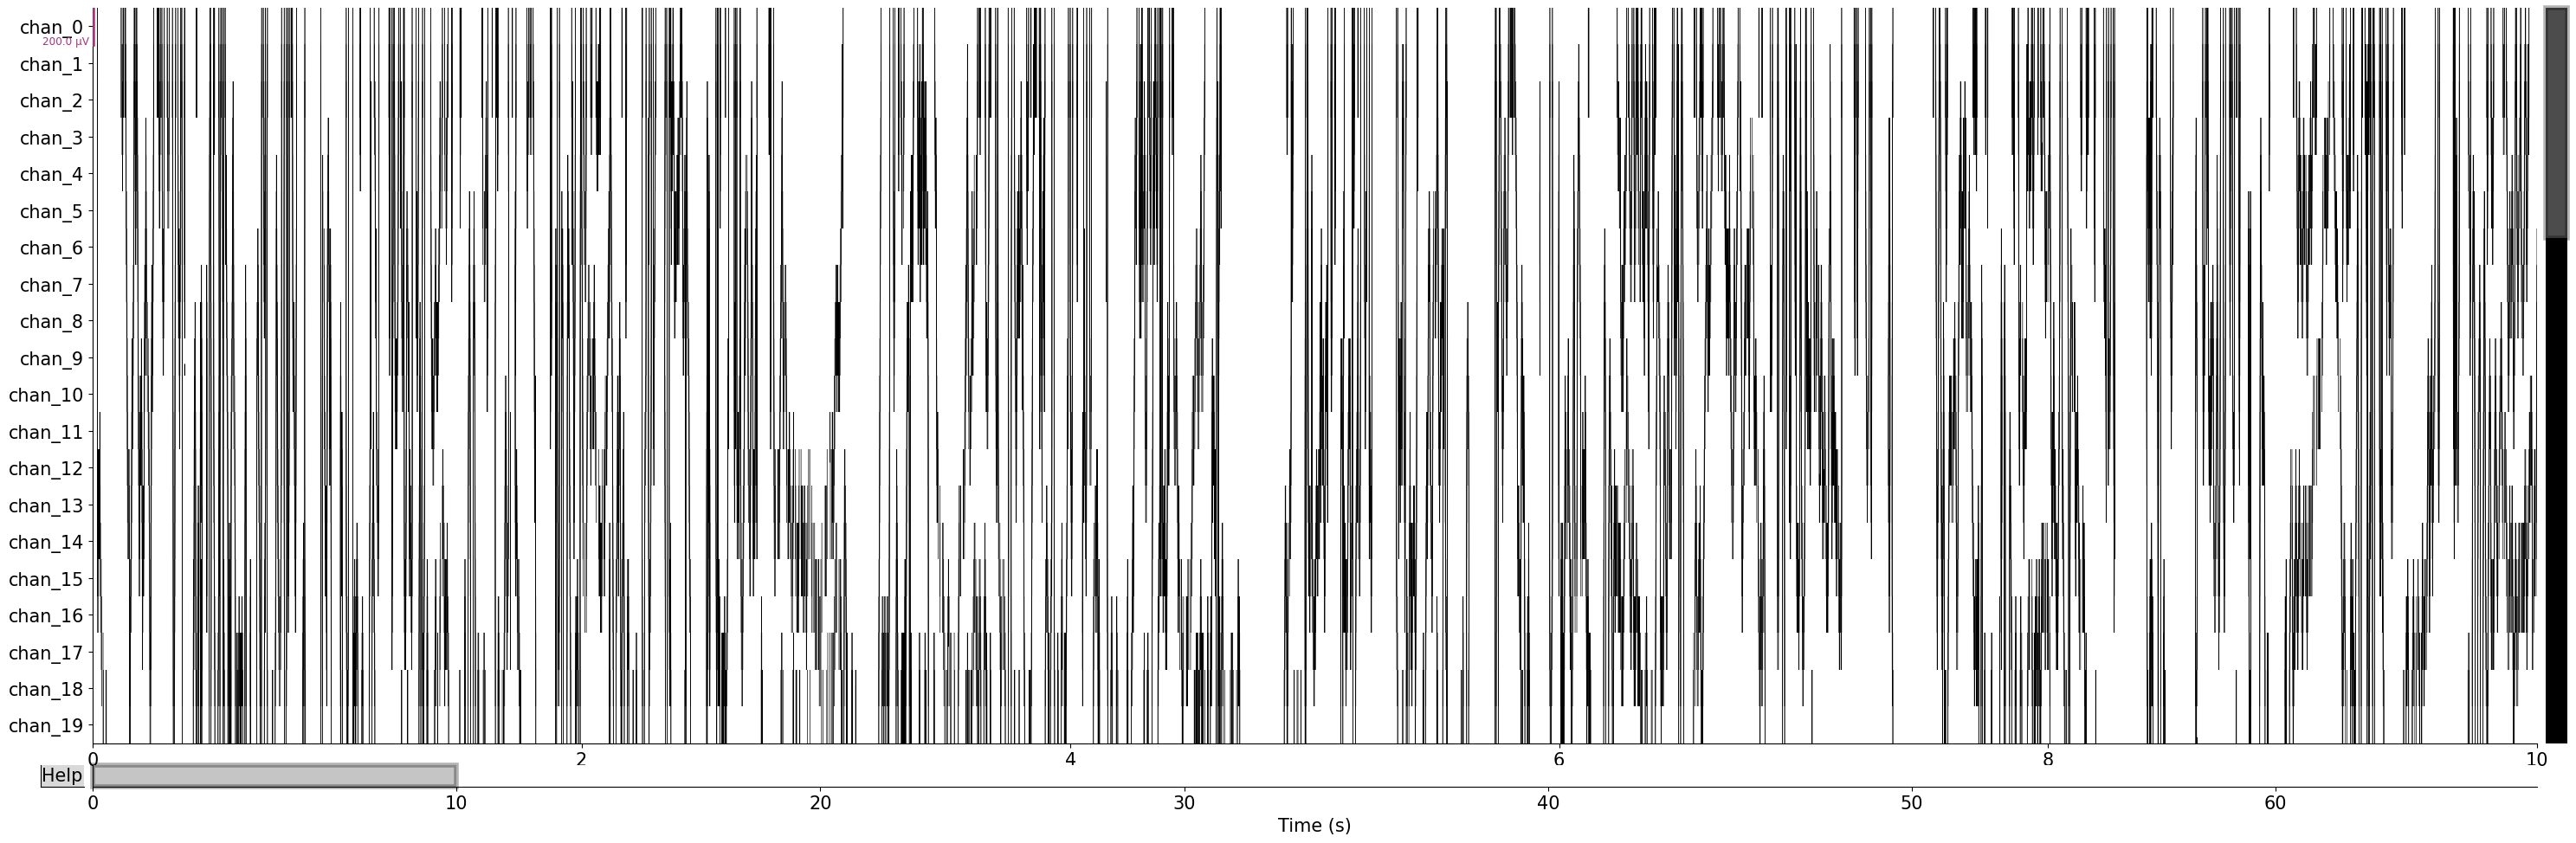

In [186]:
import mne
dat = alldat[0][2]
V = dat['V'].astype('float32')
V = full_alpha_band(V)

sfreq = 1000
n_chan = len(V[0])
n_times = len(V)
data = V.T
times = np.arange(n_times) / sfreq
channels = [f'chan_{i}' for i in range(n_chan)]
ch_types = ['ecog'] * n_chan
mne.set_config('MNE_BROWSE_RAW_SIZE','30,10')  
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data, info)
raw.plot()

Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 501 original time points ...
1 bad epochs dropped
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


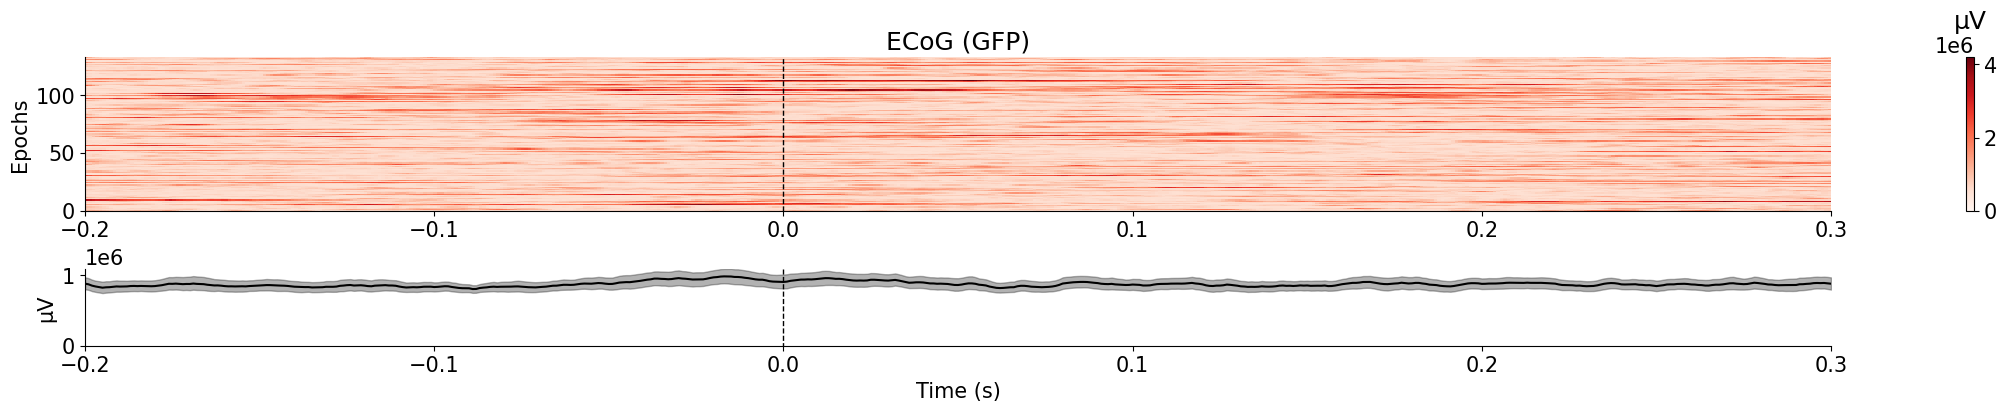

[<Figure size 2000x400 with 3 Axes>]

In [187]:
# event related potentials
from mne import Epochs, find_events
events = mne.make_fixed_length_events(raw, start=0, stop=None, duration=0.5)
event_id = {'event': 1}
tmin = -0.2
tmax = 0.3
epochs = Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
epochs.plot_image()
